In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [3]:
from ucimlrepo import fetch_ucirepo

wine = fetch_ucirepo(id=109) 

# data (as pandas dataframes) 
x = wine.data.features 
y = wine.data.targets 

# variable information 
print(x.dtypes) 

Alcohol                         float64
Malicacid                       float64
Ash                             float64
Alcalinity_of_ash               float64
Magnesium                         int64
Total_phenols                   float64
Flavanoids                      float64
Nonflavanoid_phenols            float64
Proanthocyanins                 float64
Color_intensity                 float64
Hue                             float64
0D280_0D315_of_diluted_wines    float64
Proline                           int64
dtype: object


# Feature Transformations and Scaling

In [4]:
x = pd.DataFrame(x)

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize = (16,12))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

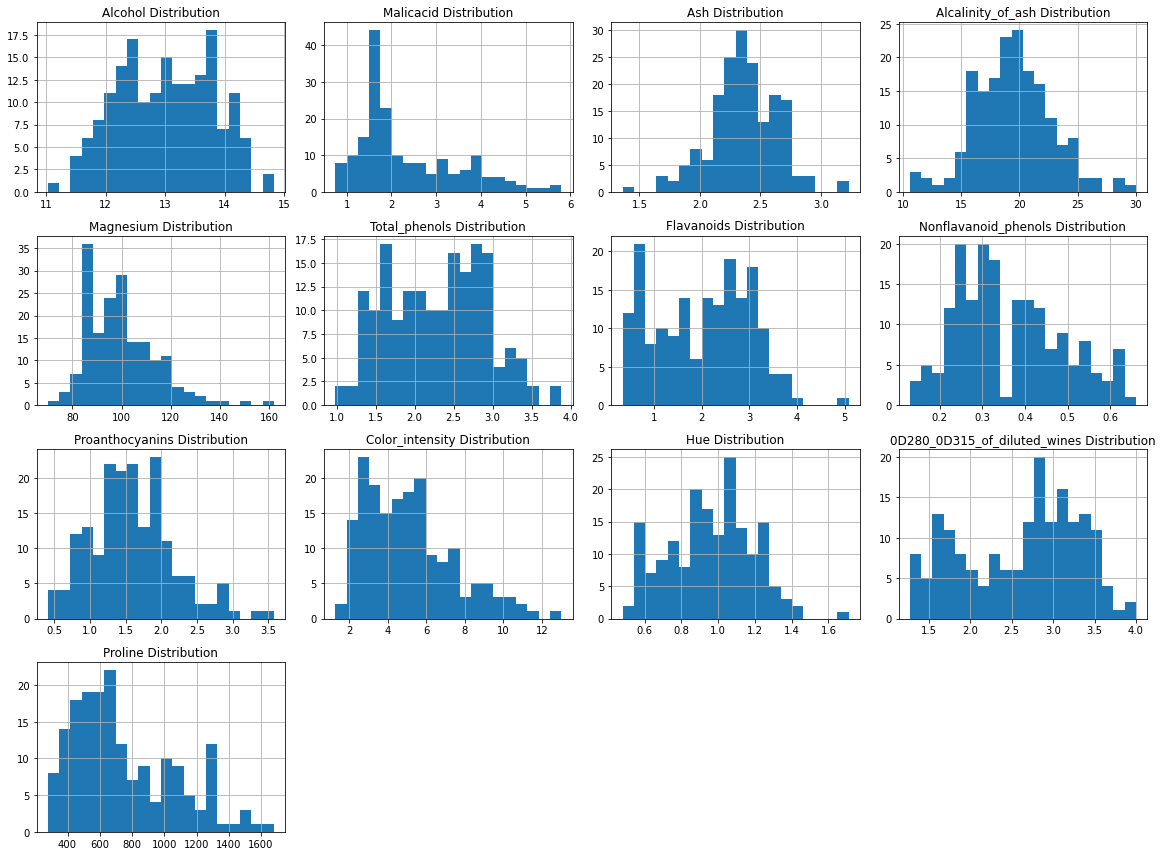

In [5]:
# figures before transformations:
draw_histograms(x, x.columns, 4, 4)

In [6]:
# Numeric transformations
x['Malicacid'] = np.log(x.Malicacid)
x['Color_intensity'] = np.log(x.Color_intensity)
x['Proline'] = np.log(x.Proline)

In [7]:
x = x.rename(columns={'Malicacid':'log_Malicacid', 'Color_intensity':'log_Color_intensity','Proline':'log_Proline'})

In [8]:
# figures after transformations:
#draw_histograms(x, x.columns, 4, 4)

In [9]:
clip_var = [ 'Ash', 'Magnesium', 'Flavanoids', 'Hue', 'Proanthocyanins']

for i in clip_var:
    transformed = 'clipped_' + i
    
    upper_limit = x[i].quantile(0.975)
    lower_limit = x[i].quantile(0.025)
    
    x[transformed] = x[i].clip(lower_limit, upper_limit, axis=0)

In [10]:
x = x.drop(columns = clip_var)

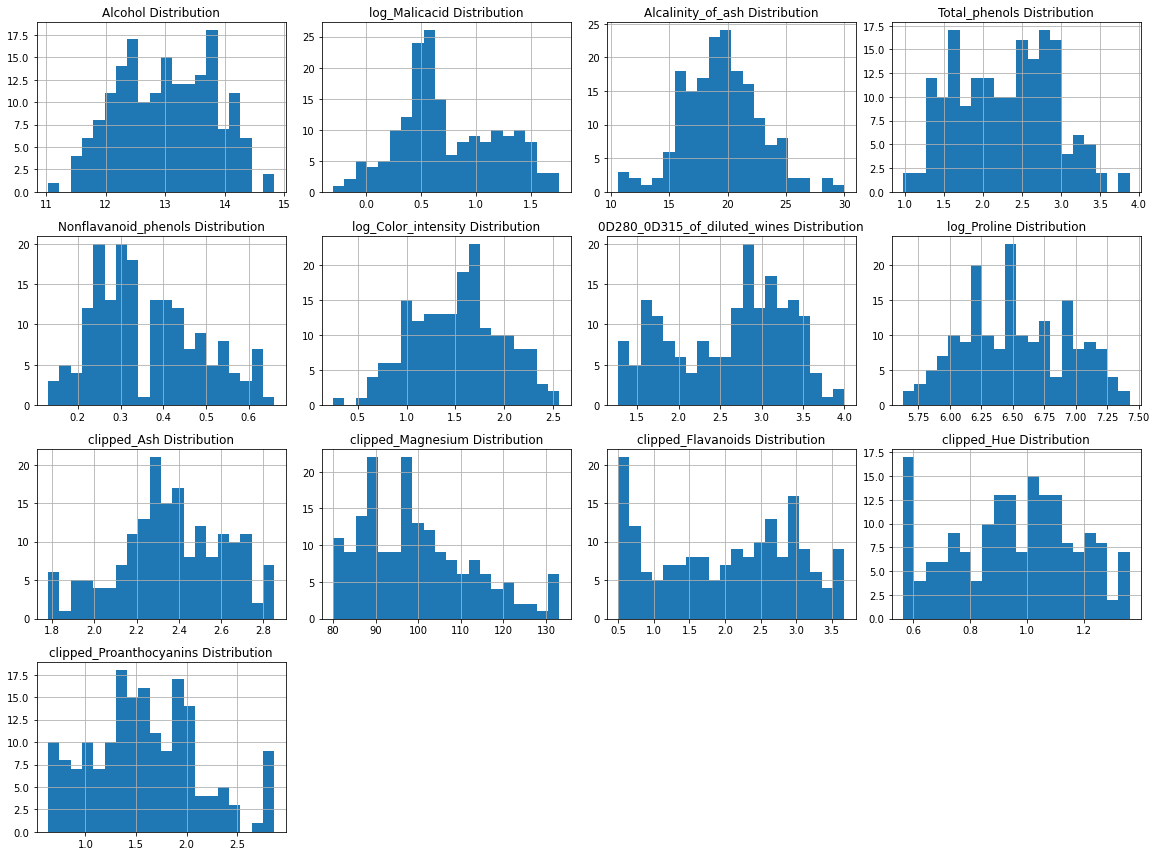

In [11]:
# feature distributions after transformations
draw_histograms(x, x.columns, 4, 4)

In [12]:
# MinMax Scaling
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
print(x_scaled)

[[0.84210526 0.40680598 0.25773196 ... 0.80500431 0.59786365 0.74207235]
 [0.57105263 0.42629151 0.03092784 ... 0.71087928 0.61043041 0.29097812]
 [0.56052632 0.5632771  0.41237113 ... 0.86147933 0.58529689 0.97431889]
 ...
 [0.58947368 0.85239904 0.48453608 ... 0.06141658 0.03235941 0.32224207]
 [0.56315789 0.60844365 0.48453608 ... 0.05827908 0.04492617 0.37137115]
 [0.81578947 0.83153124 0.71649485 ... 0.08337909 0.05749293 0.32224207]]


In [13]:
# transform the matrix into a DataFrame
x_scaled_df = pd.DataFrame(x_scaled, columns = x.columns)

# KNN for Classification

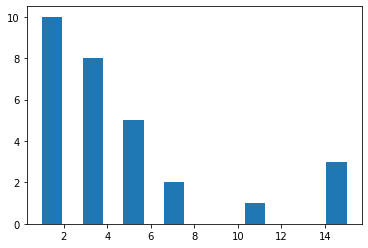

In [14]:
# Find the best number of clusters using cross validation

results = []
neighbors_range = list(range(1, 21))
for random_state in range(1,30):
    X_train, X_test, y_train, y_test = train_test_split(x_scaled_df, y, test_size = 0.2, random_state =random_state)

    param_grid = {'n_neighbors': neighbors_range}

    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, np.ravel(y_train))

    best_n_neighbors = grid_search.best_params_['n_neighbors']
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append([random_state, best_n_neighbors, accuracy])

results = pd.DataFrame(results, columns = ['random_state','best_n','accuracy'])

# plot a histogram for the best number of clusters, n=3 it is
plt.hist(results.best_n, bins =15)
plt.show()

In [15]:
# split the data into train and test, since it's a small dataset, let's use test size = 33% 

x_train, x_test, y_train, y_test = train_test_split(x_scaled_df, y, test_size = 0.33, random_state =11)

In [16]:
# fit the model for 3 clusters

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, np.ravel(y_train))

y_predict = knn.predict(x_test)


In [17]:
# Evaluate the model accuracy, precision, recall and f1

print('accuracy score', accuracy_score(y_test, y_predict))
print('precision score', precision_score(y_test,y_predict, average=None))
print('recall score', recall_score(y_test,y_predict, average=None))
print('f1 score', f1_score(y_test,y_predict, average=None))

accuracy score 0.9491525423728814
precision score [0.91304348 1.         0.93333333]
recall score [1.    0.875 1.   ]
f1 score [0.95454545 0.93333333 0.96551724]


In [18]:
#visualize model performance with the confusion matrix

conf_matrix = confusion_matrix(y_test, y_predict)
conf_matrix = pd.DataFrame(conf_matrix, columns=['Pred C1', 'Pred C2', 'Pred C3'])
conf_matrix.index = ['Actual C1', 'Actual C2', 'Actual C3']
print(conf_matrix)

           Pred C1  Pred C2  Pred C3
Actual C1       21        0        0
Actual C2        2       21        1
Actual C3        0        0       14


# Decision Tree for Classification

In [19]:
#Initiate and fit the Decision Tree Classifier 
depths = range(1,13)
acc_depth = []
for i in depths:
    dt = DecisionTreeClassifier(max_depth=i, ccp_alpha=0.01,criterion='gini', random_state=11)
    dt.fit(x_train, y_train)
    score = dt.score(x_test, y_test)
    acc_depth.append([i,score])

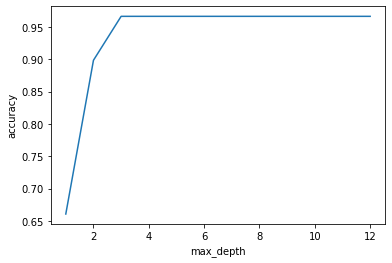

In [20]:
#Plot the accuracy vs depth
acc_depth = pd.DataFrame(acc_depth, columns=['depth','score'])
plt.plot(acc_depth.depth, acc_depth.score)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

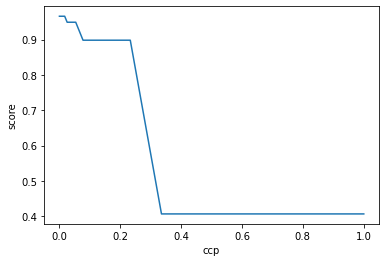

        ccp     score
0  0.001000  0.966102
1  0.001438  0.966102
2  0.002069  0.966102
3  0.002976  0.966102
4  0.004281  0.966102
5  0.006158  0.966102
6  0.008859  0.966102
7  0.012743  0.966102
8  0.018330  0.966102


In [21]:
# Find the best values for ccp_alpha
ccp = np.logspace(-3,0,num=20)
acc_pruned = []

for i in ccp:    
    dt = DecisionTreeClassifier(max_depth = 3, ccp_alpha = i, criterion='gini', random_state=11)
    dt.fit(x_train, y_train)
    score = dt.score(x_test, y_test)
    acc_pruned.append([i,score])

acc_pruned = pd.DataFrame(acc_pruned, columns = ['ccp', 'score'])
max_score = np.max(acc_pruned.score)

plt.plot(acc_pruned.ccp, acc_pruned.score)
plt.xlabel("ccp")
plt.ylabel("score")
plt.show()

print(acc_pruned[acc_pruned.score == max_score])

Accuracy Score: 0.9152542372881356


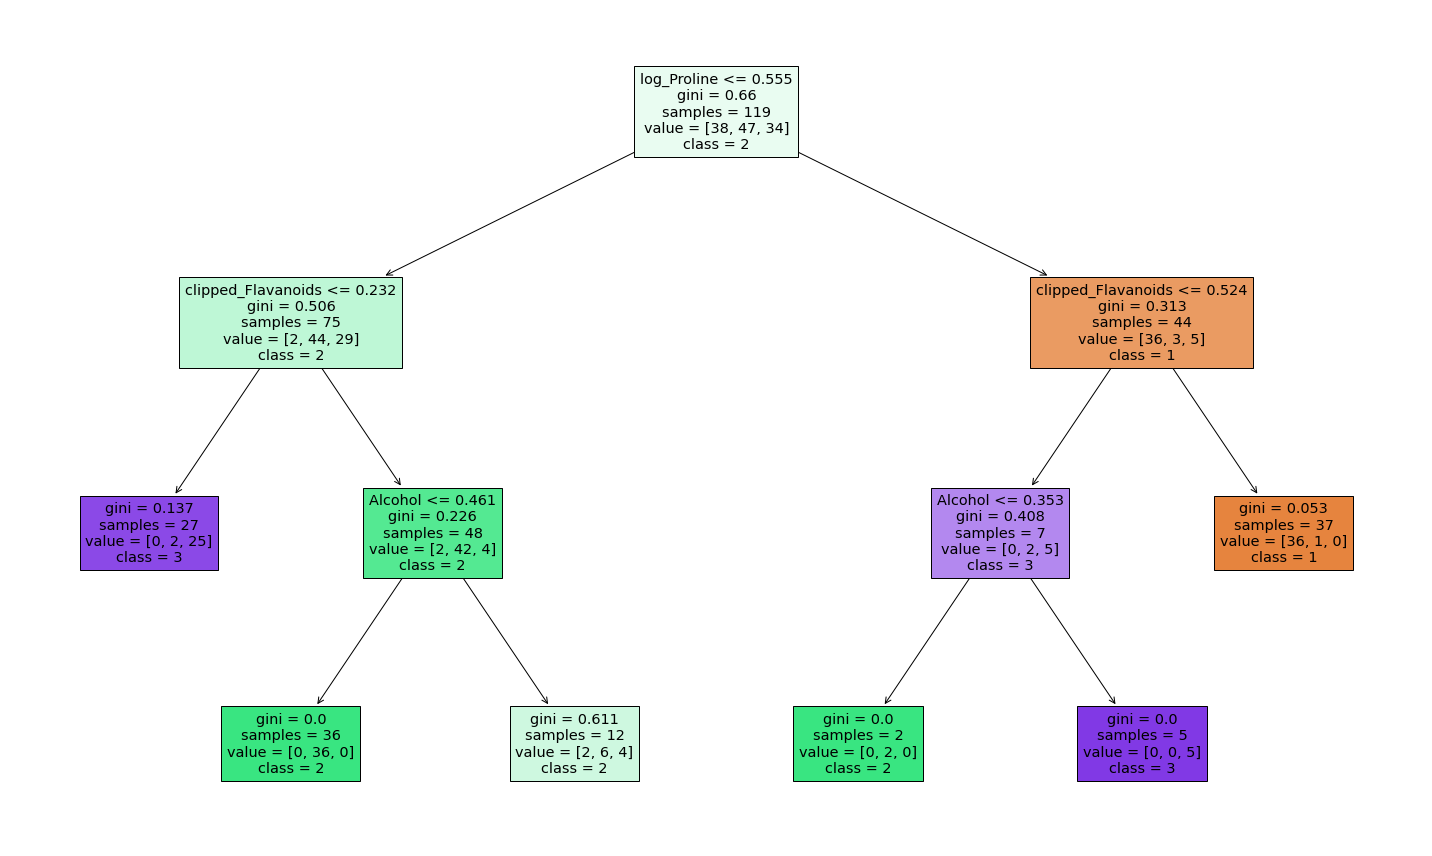

In [30]:
# fit and plot the Decision Tree using max_depth =3 and ccp_alpha=0.01833

dt = DecisionTreeClassifier(max_depth=3, ccp_alpha=0.01833, criterion='gini', random_state=11)
dt.fit(x_train, y_train)
print(f'Accuracy Score: {dt.score(x_test, y_test)}')
y_pred = dt.predict(x_test)

plt.figure(figsize=(20,12))
tree.plot_tree(dt, feature_names = x_train.columns, max_depth=3, class_names = ['1', '2','3'], label='all', filled=True)
plt.tight_layout()
plt.show()

In [31]:
dt_conf_matrix = confusion_matrix(y_test, y_pred)
dt_conf_matrix = pd.DataFrame(dt_conf_matrix, columns = ['Pred 1', 'Pred 2', 'Pred 3'])
dt_conf_matrix.index = ['Actual 1', 'Actual 2', 'Actual 3']
print(dt_conf_matrix)

          Pred 1  Pred 2  Pred 3
Actual 1      21       0       0
Actual 2       1      22       1
Actual 3       0       3      11


# Logistic Regression Classification

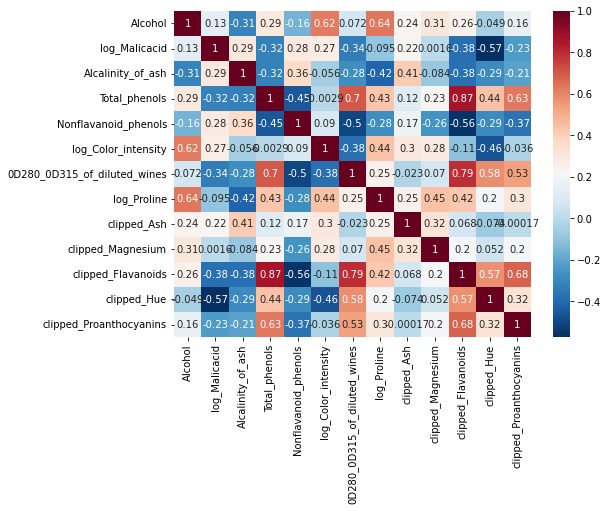

In [23]:
# Test for high correlation between variables

correlation_matrix = x_scaled_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r')
plt.show()

# clipped_Flavanoids, Total_phenols and 0D280_0D315_of_diluted_wines are highly correlated

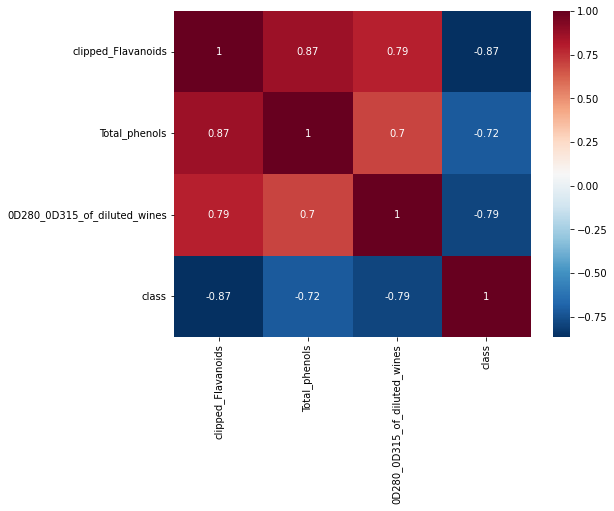

In [24]:
# Analyze and Trim the variables that are highly correlated

# create a new df containing the correlated variables with the target variable
x_y = x_scaled_df.copy()
x_y = x_y[['clipped_Flavanoids','Total_phenols','0D280_0D315_of_diluted_wines']]
x_y['class'] = y

# create a heatmap to visualize the correlation with the target variable
corr_matrix = x_y.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

# since clipped_Flavanoids has the highest correlation with the target variable, we will keep it and drop the rest
x_trimmed = x_scaled_df.drop(columns=['Total_phenols','0D280_0D315_of_diluted_wines'])

In [25]:
# Filter features by Mutual Information

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from functools import partial

#print(mutual_info_regression(x_trimmed, np.ravel(y), discrete_features=[0], random_state=68))
#print(x_trimmed.columns)

# We use this to include multiple parameters in the SelectKBest function
score_func = partial(mutual_info_regression, discrete_features=[0], random_state=68)

# Select top 5 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=3)

selection.fit_transform(x_trimmed, np.ravel(y)) # output is a np matrix

# Use .get_support() to transform it into a dataframe
x_trim = x_trimmed[x_trimmed.columns[selection.get_support(indices=True)]]

# Outcome is a dataframe with 3 remaining features with the highest mutual info
print(x_trim.columns)

Index(['Alcohol', 'log_Proline', 'clipped_Flavanoids'], dtype='object')


In [26]:
# Create and Fit a LogisticRegression Model into the trimmed dataset

from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(x_trim, y, test_size = 0.33, random_state=11)

model = LogisticRegression()
model.fit(x_train, np.ravel(y_train))

y_pred = model.predict(x_test)

print(x_train.head())
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

      Alcohol  log_Proline  clipped_Flavanoids
63   0.352632     0.229377            0.817554
94   0.155263     0.120029            0.554004
54   0.713158     0.744000            0.754804
101  0.413158     0.391278            0.271629
99   0.331579     0.210532            0.783042
Coefficients: [[ 1.54737071  2.31639173  2.61325945]
 [-2.48503399 -2.08178828  0.90193713]
 [ 0.93766328 -0.23460345 -3.51519658]]
Intercept: [-3.28922903  2.26677033  1.02245871]


In [27]:
# Evaluate the model accuracy, precision, recall and f1

print('accuracy score:', accuracy_score(y_test, y_pred))
print('precision score:', precision_score(y_test,y_pred, average=None))
print('recall score:', recall_score(y_test,y_pred, average=None))
print('f1 score:', f1_score(y_test,y_pred, average=None))


accuracy score: 0.9661016949152542
precision score: [0.95454545 1.         0.93333333]
recall score: [1.         0.91666667 1.        ]
f1 score: [0.97674419 0.95652174 0.96551724]


In [28]:
confusion_matr = confusion_matrix(y_test, y_pred)
confusion_matr= pd.DataFrame(confusion_matr, columns = ['Pred_C1', 'Pred_C2', 'Pred_C3'])
confusion_matr.index = ['Actual_C1','Actual_C2','Actual_C3']
print(confusion_matr)

           Pred_C1  Pred_C2  Pred_C3
Actual_C1       21        0        0
Actual_C2        1       22        1
Actual_C3        0        0       14
